In [86]:
"""Cell:Utility"""
import numpy as np
from scipy import pi
from matplotlib import pyplot as plt
def np_concatenate(x_array):
    """Returns np array corresponding to the cocatenation of all the np arrays in x_array"""
    z = []
    for cur_array in x_array:
        for i in range(len(cur_array)):
            z.append(cur_array[i])   
    z = np.array(z)
    return z
    
    
def get_max_range(x, tolerance):
    """Returns the indices and values for all values >= tolerance*maximum"""
    max_indices = []
    max_values = [] 
    max_value = max(x)

    for k,elem in enumerate(x):
        if elem >= tolerance*max_value:
            max_values.append(elem)
            max_indices.append(k)

    return [max_indices, max_values] 


def complex_dot(x, y):
    """Returns dot product of x with conjugate of y (inner product of x and y)"""
    if len(x) != len(y):
        raise ValueError("Input vectors need to be of same size but size x is " + str(len(x)) + " while size y is " + str(len(y)))
    else:     
        dot_xy = sum(x[i]*np.conj(y[i]) for i in range(len(x)))
        return dot_xy


def complex_correlation(x, y):    
    """Returns complex correlation (between -1 and 1 of the vectors x,y)"""
    if len(x) != len(y):
        raise ValueError("Input vectors need to be of same size but size x is " + str(len(x)) + " while size y is " + str(len(y)))
    else:
        correlation_xy = complex_dot(x,y)/np.sqrt(complex_dot(x,x)*(complex_dot(y,y)))
        return (correlation_xy)

def correlate(x, y): 
    '''Returns x.y/sqrt(x.x*y.y) '''
    if(len(x) == len(y)):
        num = np.sum(np.multiply(x,y))
        den = np.sqrt(np.sum(np.multiply(x,x))*np.sum(np.multiply(y,y)))
        if den is not 0:
            return num/den
        else:
            return 1
    else:
        raise ValueError("Length of x = " + str(len(x)) + " does not match length of  y = "  + str(len(y)))  
        
def to_scale(x, scale =1):
    x = np.array(x)
    y = scale*x/max(abs(x))
    return y

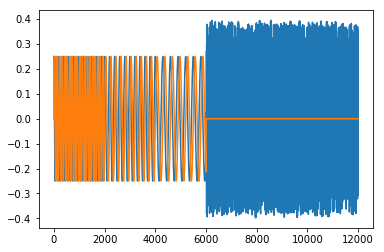

5000.0 200
2500.0 2200
1666.6666666666667 4200


In [87]:
"""Cell:Complex input"""
len_tone = 2000

data_to_tone_ratio  = 1
sampling_frequency = 500e3
input_multiply_constant = 0.25

tone_frequencies = [ sampling_frequency/100.0, sampling_frequency/200.0, sampling_frequency/300.0] 
len_data = len(tone_frequencies)*len_tone*data_to_tone_ratio
tone_margin = 0.1
correlation_dict = {}
file_source_complex_expt2  = "./logs/fileSourceComplexExpt2"

def get_complex_data():
    '''Returns complex values corresponding to input read from file sink of expt 1 '''    
    complex_data = np.fromfile(file_source_complex_expt2, dtype = 'complex64')
#     print(len_data)
    complex_data = complex_data[len_tone*len(tone_frequencies):len_tone*len(tone_frequencies) +len_data]
    return complex_data

def get_complex_tones():
    """Returns complex values corresponding to input sine tones """
   
    y = []
    x = np.array(range(len_tone))
    for k,tone_frequency in enumerate(tone_frequencies):
        cur_start = k*len_tone     
        y_temp = np.array(np.exp(x*2.0j*pi*tone_frequency/sampling_frequency))
        correlation_dict[tone_frequency] = {}
        correlation_dict[tone_frequency]['start'] = cur_start + int(len_tone*tone_margin)
        correlation_dict[tone_frequency]['wave'] = y_temp[int(len_tone*tone_margin):int(len_tone*(1 - tone_margin))]
        for i in range(len(y_temp)):
            y.append(y_temp[i])

    complex_tones = np.array(y, dtype = 'complex64')   
    return complex_tones


def get_complex_input():
       
    complex_tones = get_complex_tones()
    complex_data = get_complex_data()
    complex_input = input_multiply_constant*np.concatenate([complex_tones,complex_data] , axis = 0)
    return complex_input

complex_input = get_complex_input()
plt.plot(complex_input.real)
plt.plot(complex_input.imag)
plt.show()
for key in correlation_dict:
    print(key, correlation_dict[key]['start'])

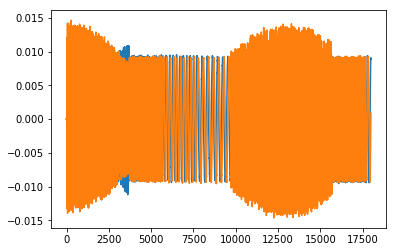

In [88]:
"""Cell:Complex output"""
file_sink_complex_expt2  = "./logs/fileSinkComplexExpt2_6"
def read_output():  
    """Reads the complex values from output file sink generated by gnuradio expt 2"""
    
    complex_output = np.fromfile(file_sink_complex_expt2, dtype = 'complex64').reshape(-1,1)  
    plt.plot(complex_output[11:18000].real)
    plt.plot(complex_output[11:18000].imag)
    plt.show()
    
    return complex_output
    
complex_output = read_output()


In [89]:
"""Cell:Output segmentation"""

"""
    Segments the output stream into [tones + data ] windows based on coarse lag estimates
    Returns a list of tuples [start, np.array(y)]
    start:the sample in output stream where the current window starts
    
"""

data_to_tone_ratio  = 1
len_data = len(tone_frequencies)*len_tone*data_to_tone_ratio
max_lag_end = len(tone_frequencies)*(len_tone*2) + len_data
min_lag_start = 0
max_tolerance_threshold = 0.99
lag_jump = 5
len_window = len(tone_frequencies)*(len_tone) + len_data #Since equal length of tones to data

def get_lag_estimate(complex_output):
    '''Returns best lag estimate based on coarse timing synchronization using tones'''
   
    lag_start = min_lag_start;
    lag_est_array = []
    for tone_frequency in tone_frequencies:
        start = correlation_dict[tone_frequency]['start']
        cur_x = correlation_dict[tone_frequency]['wave']
        print ('Correlating for wave starting at ' + str(start) + '...')
     
        lag_end = min(max_lag_end, len(complex_output) - len(cur_x) )


        corr_array = []
        lag_array = []
        for lag in np.arange(lag_start, lag_end+1, lag_jump):
            cur_y = complex_output[lag:lag+len(cur_x), 0]

            cur_corr = correlate(abs(cur_x.real), abs(cur_y.real))
            corr_array.append(cur_corr)
            lag_array.append(lag)
            # print ('Lag: ' + str(lag) + ', Corr: ' + str(cur_corr))

        [max_indices, max_range] = get_max_range(corr_array, tolerance=max_tolerance_threshold)
        
        cur_lag_array = []
        for index in max_indices:
            cur_lag_array.append(lag_array[index])

        print('---Max Lags')
        print('---' + str(cur_lag_array))
        print('---Max Values')
        print('---'+ str(max_range))

        # cur_est_lag = cur_lag_array[len(cur_lag_array)//2] - start 
        cur_est_lag = cur_lag_array[len(cur_lag_array)-1] - start 

        print('---Current Estimated Lag: ' + str(cur_est_lag))
        lag_est_array.append(cur_est_lag)
  
    lag_estimate = lag_est_array[len(lag_est_array)//2]
    print('Final estimated lag: ' + str(lag_estimate))
    
    return lag_estimate


def get_distorted_output_array(complex_output):
    coarse_lag_estimate = get_lag_estimate(complex_output)

    window_start = coarse_lag_estimate
    window_end = window_start + len_window
    max_windows = float('inf')
    cur_num_window = 0

    distorted_output_array = []

    while window_end < len(complex_output) and cur_num_window < max_windows:
        cur_y = complex_output[window_start:window_end]
        distorted_output_array.append([window_start, cur_y])   
        window_start += len_window
        window_end =  window_start + len_window
        cur_num_window += 1
    
    print("Total of " + str(len(distorted_output_array)) + " windows ")
    return distorted_output_array
    
distorted_output_array = get_distorted_output_array(complex_output)

Correlating for wave starting at 200...
---Max Lags
---[3655, 3705, 3755, 3805, 3855, 3905, 3955, 4005, 4055, 4105, 4155, 15750, 15800, 15850, 15900, 15950, 16000, 16050, 16100, 16150]
---Max Values
---[0.98528072633144925, 0.99156451828212466, 0.99224134541167641, 0.99295447602884723, 0.99334818193287489, 0.99379322121239644, 0.99392126508171774, 0.99416869543035913, 0.99400842826799052, 0.99402765517751146, 0.9878184316545443, 0.9850560974890672, 0.98652354497342343, 0.98768431903184373, 0.98897934109723018, 0.98994268506434013, 0.99098546086688966, 0.99173605670909781, 0.99258469219225831, 0.98663251965196619]
---Current Estimated Lag: 15950
Correlating for wave starting at 2200...
---Max Lags
---[5710, 5715, 5810, 5815, 5910, 5915, 6010, 6015, 6110, 6115, 17695, 17700, 17800, 17805, 17900, 17905, 18000]
---Max Values
---[0.99331564032110253, 0.98892637525174321, 0.99191663745205483, 0.99069708950117619, 0.99051348384461957, 0.99257598799994884, 0.9881099424728319, 0.993344574758314

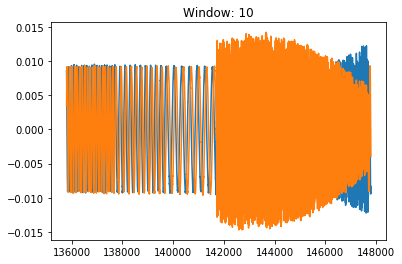

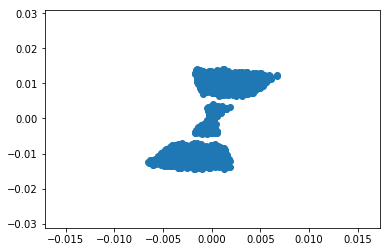

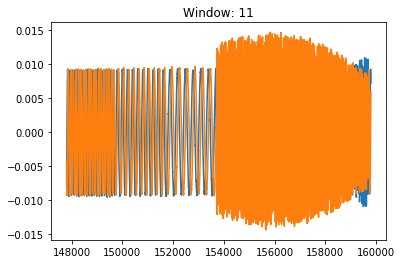

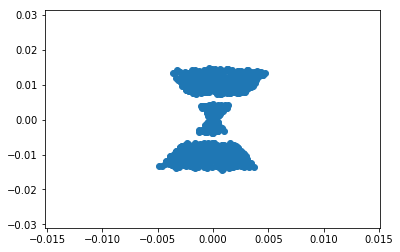

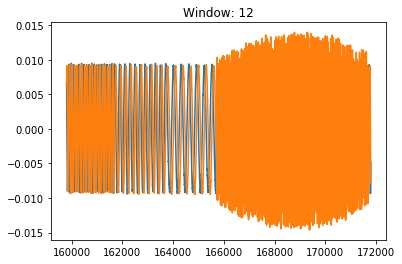

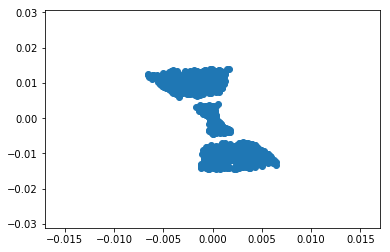

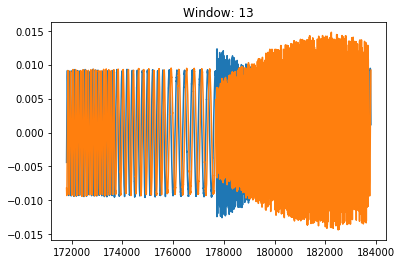

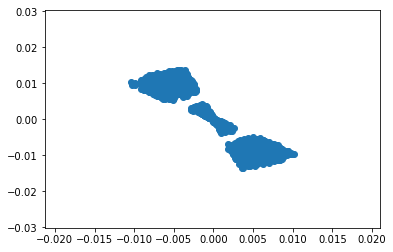

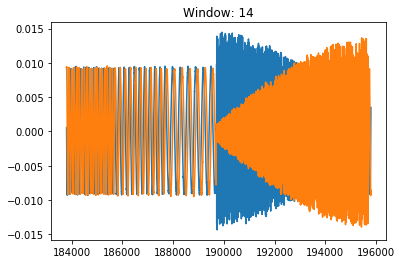

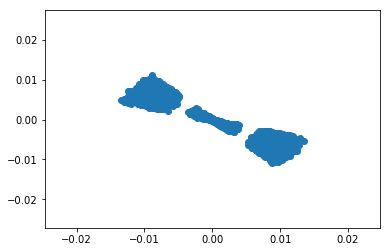

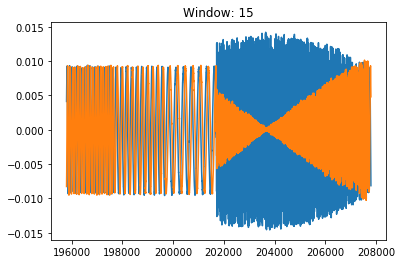

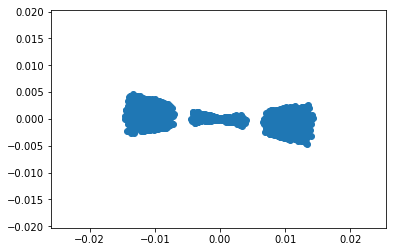

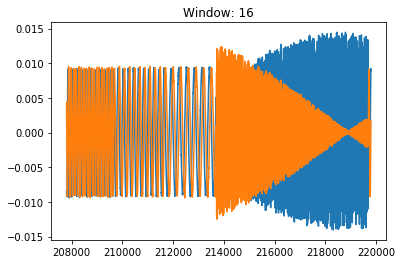

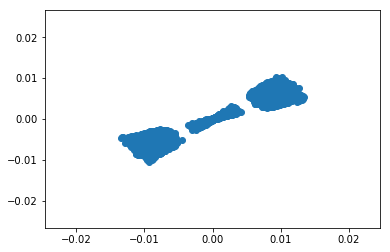

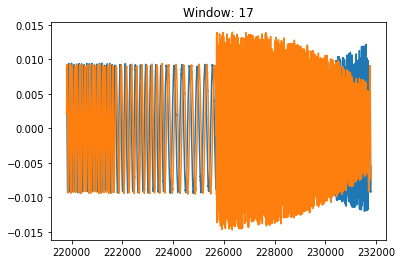

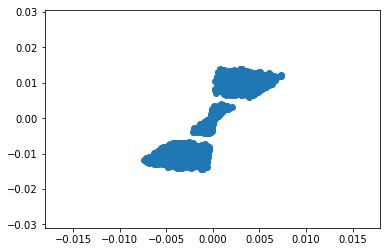

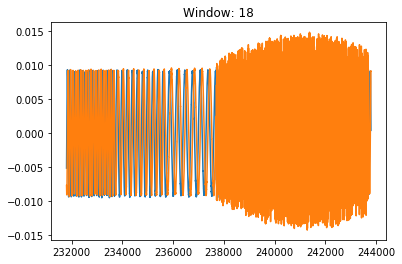

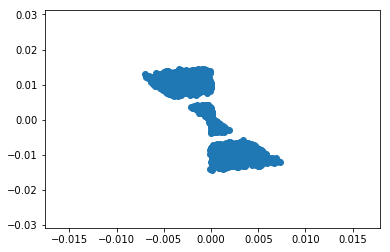

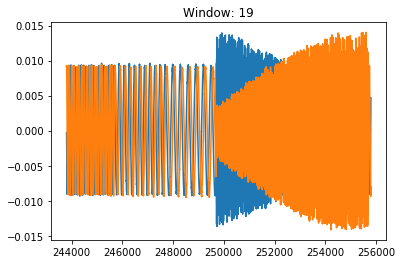

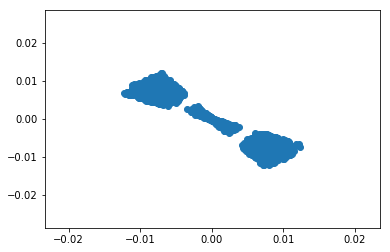

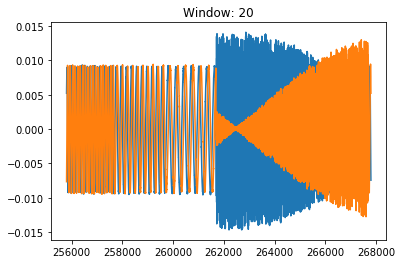

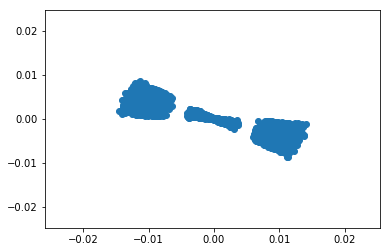

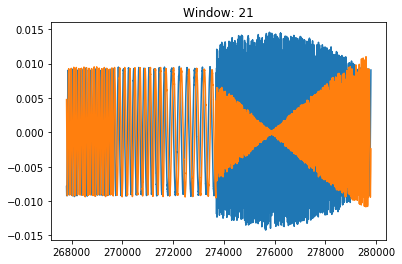

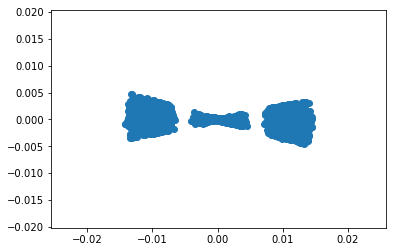

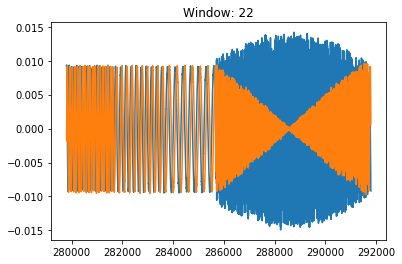

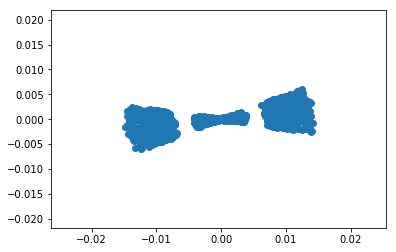

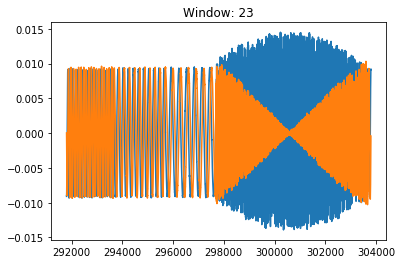

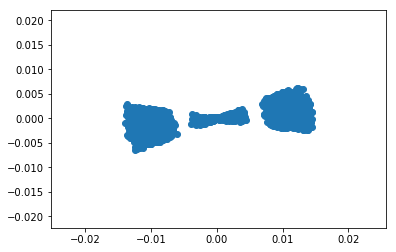

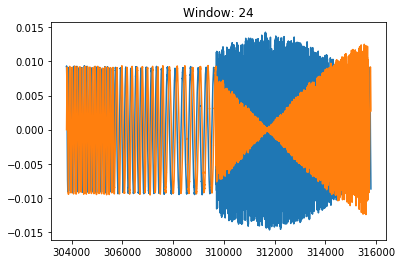

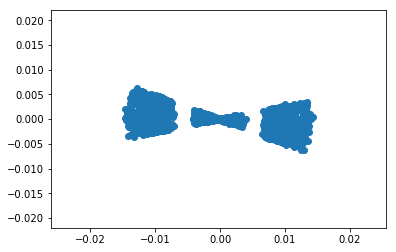

In [90]:
"""Cell:Test output segmentation"""
for idx in range(10,25):
    x = range(distorted_output_array[idx][0], distorted_output_array[idx][0] + len(distorted_output_array[idx][1]))
    plt.plot(x,distorted_output_array[idx][1].real)
    plt.plot(x,distorted_output_array[idx][1].imag)
    plt.title('Window: ' + str(idx))
    plt.show()
    
    complex_vector = distorted_output_array[idx][1]
    plt.scatter(complex_vector[7000:9500].real, complex_vector[7000:9500].imag)
    plt.show()
    


In [91]:
"""Cell:Correct carrier frequency offset"""

len_region = int(len_tone/3) #This controls how good carrier frequency offset is

def get_pure_tone_frequency(complex_vector, index, region):
    """Get frequency of the pure tone in a range of 'region', around 'index' in complex_vector"""
    
    tone_values = []
    for i in range(index - region//2, index + region//2):
        if i >= 0 and i < len(complex_vector):
            tone_values.append(complex_vector[i])
    
    predicted_freq_array = []
    for i in range(1,len(tone_values)):
        tone_ratio = tone_values[i]/tone_values[i-1]
        cur_predicted_freq = float(np.angle(tone_ratio)/(2*pi))
        predicted_freq_array.append(cur_predicted_freq)
    
#     print(predicted_freq_array)
    predicted_freq =  np.mean(predicted_freq_array)
    return predicted_freq

def get_carrier_frequency_offset(complex_vector, complex_input, region):
    """Returns the predicted carrier frequency offset"""   
    freq_diff_array = []
    for tone_frequency in tone_frequencies:
        input_freq = get_pure_tone_frequency(complex_input, index = int(correlation_dict[tone_frequency]['start'])+ len_tone//2, region = region)
        output_freq = get_pure_tone_frequency(complex_vector, index = int(correlation_dict[tone_frequency]['start']) + len_tone//2, region = region) 
        cur_freq_diff = output_freq - input_freq    
        freq_diff_array.append(cur_freq_diff)  
#         print(freq_diff_array)
    freq_diff = np.mean(freq_diff_array) 
    return freq_diff
    

def get_corrected_output_array(distorted_output_array):
    corrected_output_array = []
    for idx in range(len(distorted_output_array)):
        complex_vector = distorted_output_array[idx][1]
        freq_diff = get_carrier_frequency_offset(complex_vector, complex_input, region = len_region)

        #Generate the correcting wave
        x = np.arange(len(complex_vector))
        correcting_wave = np.exp(x*pi*(-2j)*freq_diff)

        corrected_y = [complex_vector[i]*correcting_wave[i] for i in range(len(correcting_wave))]
        corrected_y = np.array(corrected_y)

        corrected_output_array.append([freq_diff, corrected_y])
    
    return corrected_output_array


corrected_output_array = get_corrected_output_array(distorted_output_array)



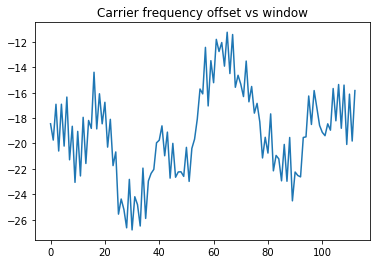

Segment: 70 Carrier frequency offset: -15.327675533Hz,  Predicted period: 32620.7322776
[ 0.01488845] 0.398126 [ 0.03739632] [-28.5434227]


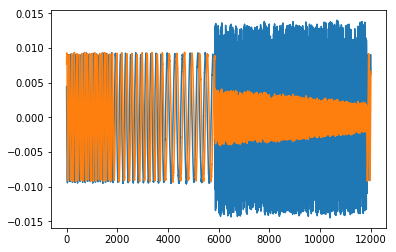

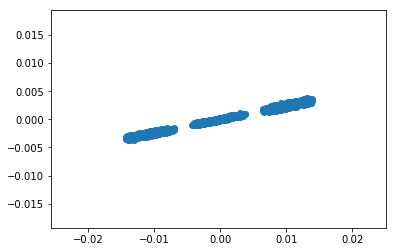

Segment: 71 Carrier frequency offset: -16.3070324325Hz,  Predicted period: 30661.6180516
[ 0.01493193] 0.398126 [ 0.03750552] [-28.51809692]


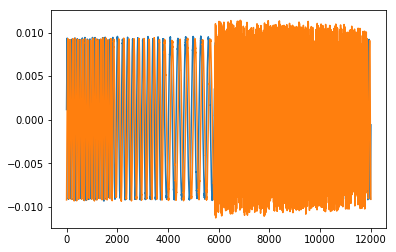

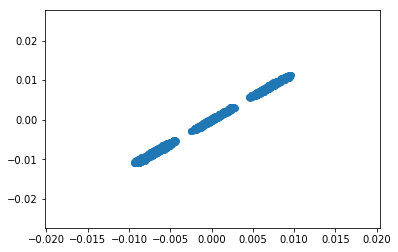

Segment: 72 Carrier frequency offset: -13.5120741987Hz,  Predicted period: 37003.9412637
[ 0.01476458] 0.398126 [ 0.03708518] [-28.61599159]


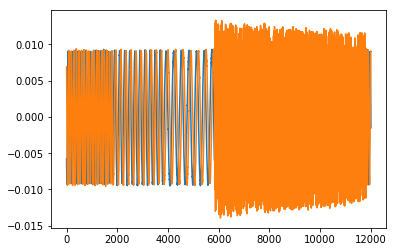

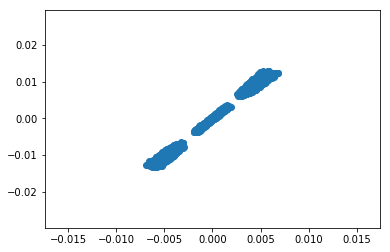

Segment: 73 Carrier frequency offset: -16.7197665986Hz,  Predicted period: 29904.7236726
[ 0.0147116] 0.398126 [ 0.0369521] [-28.6472168]


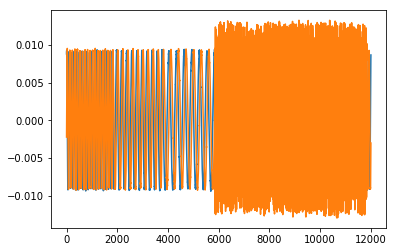

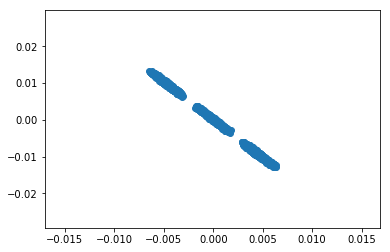

Segment: 74 Carrier frequency offset: -15.5127497461Hz,  Predicted period: 32231.5519933
[ 0.01476537] 0.398126 [ 0.03708716] [-28.61552811]


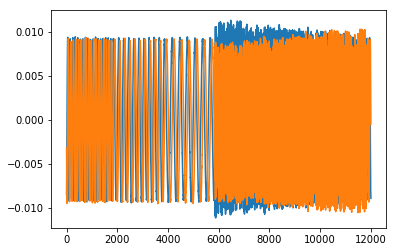

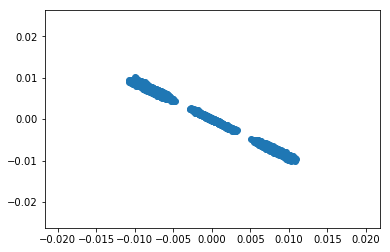

Segment: 75 Carrier frequency offset: -17.6091574363Hz,  Predicted period: 28394.3170938
[ 0.01480729] 0.398126 [ 0.03719245] [-28.59090424]


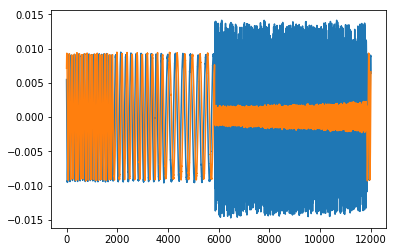

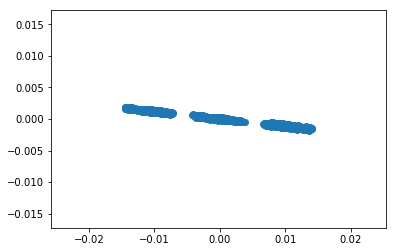

Segment: 76 Carrier frequency offset: -16.8425886685Hz,  Predicted period: 29686.6479282
[ 0.0148878] 0.398126 [ 0.03739467] [-28.54380608]


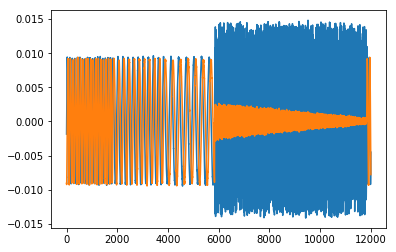

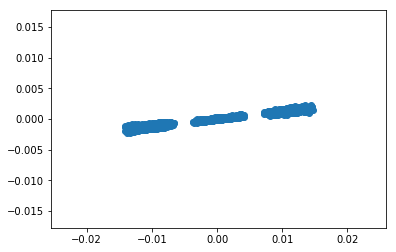

Segment: 77 Carrier frequency offset: -18.2986081789Hz,  Predicted period: 27324.482557
[ 0.01482329] 0.398126 [ 0.03723264] [-28.5815239]


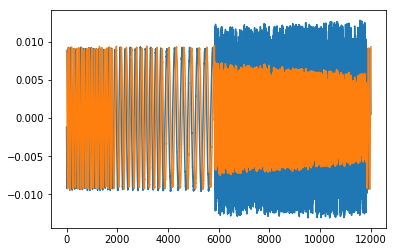

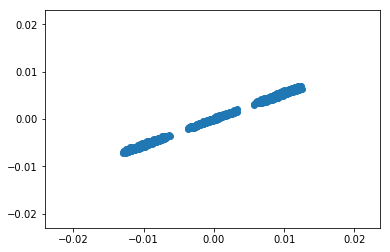

Segment: 78 Carrier frequency offset: -21.1367006405Hz,  Predicted period: 23655.5368079
[ 0.01480427] 0.398126 [ 0.03718486] [-28.59267807]


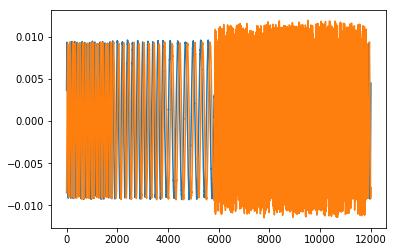

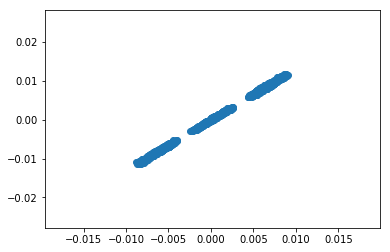

Segment: 79 Carrier frequency offset: -19.5113743895Hz,  Predicted period: 25626.0778979
[ 0.01489221] 0.398126 [ 0.03740575] [-28.54123306]


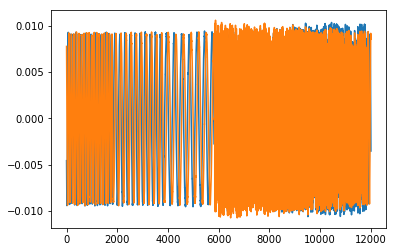

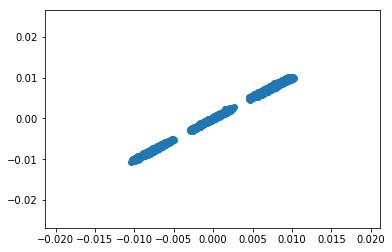

In [92]:
"""Cell:Test carrier frequency offset correction"""

carrier_freq_offset_array = [sampling_frequency*corrected_output_array[i][0] for i in range(len(corrected_output_array))]
plt.plot(carrier_freq_offset_array)
plt.title('Carrier frequency offset vs window')
plt.show()
# Main loop
for idx in range(70,80):
    complex_vector = corrected_output_array[idx][1]
    freq_diff = corrected_output_array[idx][0]
    print('Segment: ' + str(idx)+ ' Carrier frequency offset: ' + str(freq_diff*sampling_frequency) + 'Hz,  Predicted period: ' + str(1/abs(freq_diff)))
    absOutput = max(abs(complex_vector[len_tone*len(tone_frequencies):]))
    absInput =  max(abs(complex_input[len_tone*len(tone_frequencies):]))
    absRatio = absOutput/absInput;
    dbLoss = 20*np.log10(absRatio)
    
    print(absOutput, absInput, absRatio, dbLoss)
                   
    
#     plt.plot(complex_vector.real/abs(max(complex_vector.real)))
#     plt.plot(correcting_wave.real/abs(max(correcting_wave.real)))   
#     plt.show()
    
# #     plt.plot(complex_vector.imag/abs(max(complex_vector.imag)))
# #     plt.plot(correcting_wave.imag/abs(max(correcting_wave.imag)))
# #     plt.show()
    

#     plt.show()
    
#     plt.plot(to_scale((complex_vector[3070:3170].real)))
#     plt.plot(to_scale((complex_vector[3070:3170].imag)))
    
#     plt.plot((np.angle(complex_vector[8070:8170])))
#     plt.plot(to_scale(abs(complex_input[8000:8100])))
    
    plt.plot(complex_vector.real)
    plt.plot(complex_vector.imag)
    plt.show()
    
    plt.scatter(complex_vector[7000:9500].real, complex_vector[7000:9500].imag)
    plt.show()



In [93]:
print(corrected_output_array[6])

[-3.2690734291376408e-05, array([[ 0.00857550-0.00415042j],
       [ 0.00863726-0.00356881j],
       [ 0.00897347-0.00301757j],
       ..., 
       [ 0.00481698-0.007791j  ],
       [ 0.00545799-0.00748178j],
       [ 0.00594637-0.00716718j]], dtype=complex64)]


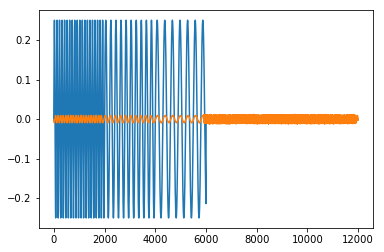

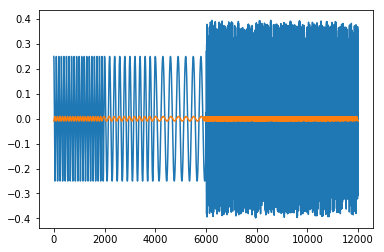

In [94]:
%matplotlib inline
plt.plot(complex_input.imag)
plt.plot(corrected_output_array[0][1].imag)
plt.figure()
plt.plot(complex_input.real)
plt.plot(corrected_output_array[0][1].real)

In [95]:
def middle_point():
    return len_tone * len(tone_frequencies)

len_pure_tones = middle_point()


In [102]:
"Cell: Channel Estimate"

def get_channel_estimate_with_numtaps(
    numTaps, complexInput, complexOutput, lagSearchWindow):
    #Scan a range around the lag
    channelArray = []
    errorArray = []
    lagArray = []
    numSamplesUsed = len(complexInput) - numTaps
    start = max(-len(complexInput) // 2 + (len(complexOutput) // 2) - lagSearchWindow//2, 0)
    for i in range(lagSearchWindow):
        yStart = i + start
        yEnd = yStart + numSamplesUsed

        
#         if yEnd < len(complexOutput):
#             curY = complexInput[xStart:xEnd]
#         else:
#             raise ValueError('Index out of bounds in complex Input,' + \
#               'StartIndex: ' + str(xStart) + ', EndIndex: ' + str(xEnd) + \
#               ' Length: ' + str(len(complexInput)))

        if yStart >= 0 and yEnd < len(complexOutput):
            curY = complexOutput[yStart:yEnd]
        else:
            raise ValueError('Index out of bounds in complex Output' + \
              ', StartIndex: ' + str(yStart) + ', EndIndex: ' + str(yEnd) + \
              ' Length: ' + str(len(complexOutput)))


        # plt.plot(range(len(curX)), curX.real, 'b', range(len(curY)), curY.real, 'r')
        # plt.show()

        curX = complexInput
        matrix = []
        for i in range(numSamplesUsed):
          matrix.append([])
          for j in range(numTaps):
            matrix[i].append(curX[i + numTaps - 1 - j])

        matrix = np.array(matrix)
        matrixpinv = np.linalg.pinv(matrix)


        curChannelEstimate = np.dot(matrixpinv, curY)
        # print('------Channel Estimate: ')
        # print(curChannelEstimate)

        curError = np.linalg.norm(np.dot(matrix,curChannelEstimate) - curY,2)**2
        # print('------Error:' + str(curError))

#         lagArray.append()
        errorArray.append(curError)
        channelArray.append(curChannelEstimate)

    [minIndices, minRange] = get_min_range(errorArray, maxErrorToleranceThreshold)

    # print(minRange)
    # print(minIndices)
    yError = min(minRange)
    lenFlatRegion = len(minRange)
    channel = channelArray[minIndices[0]]

    return [yError, lenFlatRegion, channel]

maxErrorToleranceThreshold = 0.99
minTaps, maxTaps = 1, 3

def get_min_range(x, tolerance):
    '''Returns the indices and values for all values <= maximum/tolerance'''
    minIndices = []
    minRange = []
    minVal = min(x)

    for k,elem in enumerate(x):
        if elem <= minVal/tolerance:
            minRange.append(elem)
            minIndices.append(k)

    return [minIndices, minRange]

def get_channel_estimate(complexInput, complexOutput):
    '''Returns estimated channel based on matrix inversion and searching a range around lag estimates'''

    channelEstimate = []
    tapArray = []
    errorArray = []
    lenFlatRegionArray = []
    channelArray = []
    for numTaps in range(minTaps,maxTaps+1):
        print ('Getting channel estimate assuming ' + str(numTaps) + ' taps...'+ "\n")

        [yError, lenFlatRegion, channel] = get_channel_estimate_with_numtaps(
          numTaps, complexInput, complexOutput, lagSearchWindow)
        print ('Error: ' + str(yError)+ "\n")
        print('Length of flat region: ' + str(lenFlatRegion)+ "\n")

        tapArray.append(numTaps)
        errorArray.append(yError)
        channelArray.append(channel)

        # plt.plot(tapArray, errorArray, 'r')
        # plt.title('Error vs numTaps')
        # plt.ylim((0, 1e1*noiseThreshold))
        # plt.savefig('Er')
        # plt.show()
        # plt.plot(tapArray, lenFlatRegionArray, 'b')
        # plt.title('Length of flat region vs numTaps')
        # plt.show()

        #Get minimum index so that length of flat region is 2
        minIndex = -1
        predictedTaps = -1

        errorChangeArray = [0]
        for i in range(1,len(tapArray)):
           errorChange = abs(errorArray[i]-errorArray[i-1])/errorArray[i-1]
           errorChangeArray.append(errorChange)
           print(tapArray[i], i, errorArray[i], errorArray[i-1], errorChange)
           if errorChange <= 0.1 and abs(errorArray[i]) < noiseThreshold:
            minIndex = i - 1
            predictedTaps = tapArray[i-1]
            break
        # plt.plot(tapArray, errorChangeArray, 'r')
        # plt.title('Error change vs numTaps')
        # plt.show()
        channelEstimate = channelArray[minIndex]
        print("Error V/S Number of Taps:" + "\n")
        print(str(errorArray)+ "\n")
        print("Min Index: " + str(minIndex)+ "\n")
        print("Predicted numTaps: " + str(predictedTaps)+ "\n")
        print("Channel Estimate:"+ "\n")
        print(str(channelEstimate)+ "\n")
        print(str([(abs(channelEstimate[i]), np.angle(channelEstimate[i]) * 180/pi) for i in range(len(channelEstimate))]))
        
noiseThreshold = 1e-1
inputCenter = middle_point() + len_data // 2
lagSearchWindow = 1000
buffer = 2 * lagSearchWindow
numSamples = len_data // 2
windowIdx = 100
get_channel_estimate(complex_input[inputCenter - numSamples//2: inputCenter + numSamples //2], corrected_output_array[windowIdx][1][inputCenter - numSamples//2 - buffer: inputCenter + numSamples //2 + buffer])

Getting channel estimate assuming 1 taps...

Error: 0.000717191243641

Length of flat region: 1

Error V/S Number of Taps:

[0.00071719124364122422]

Min Index: -1

Predicted numTaps: -1

Channel Estimate:

[[ 0.0336083+0.01387084j]]

[(array([ 0.03635819], dtype=float32), array([ 22.42695236], dtype=float32))]
Getting channel estimate assuming 2 taps...

Error: 0.000423510918827

Length of flat region: 1

2 1 0.000423510918827 0.000717191243641 0.409486768582
Error V/S Number of Taps:

[0.00071719124364122422, 0.00042351091882692274]

Min Index: -1

Predicted numTaps: -1

Channel Estimate:

[[ 0.00147419+0.00060276j]
 [ 0.03269652+0.01349813j]]

[(array([ 0.00159266], dtype=float32), array([ 22.23860931], dtype=float32)), (array([ 0.03537318], dtype=float32), array([ 22.43234634], dtype=float32))]
Getting channel estimate assuming 3 taps...

Error: 0.000414690807927

Length of flat region: 1

2 1 0.000423510918827 0.000717191243641 0.409486768582
3 2 0.000414690807927 0.00042351091882

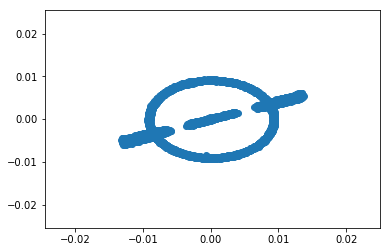

In [103]:
plt.scatter(corrected_output_array[windowIdx][1].real,  corrected_output_array[windowIdx][1].imag)